# Cosmic-Ray Rejection

This time we will learn how to reject, i.e., erase, the unwanted signals: Cosmic-rays (CR). CR is a loosely defined term in observational astronomy used to describe high energetic particles (or the resulting radiation) originated from extraterrestrial sources. On CCD image, CR appears as a dot, short streak, as shown in the following image (image credit [Tony Hallas](http://astronomy.com/magazine/tony-hallas/2010/07/tony-hallas-cosmic-imaging-getting-clean-images)):

![CRexample](http://astronomy.com/-/media/import/images/1/e/e/september-2010-cosmic-rays.jpg?mw=600)



## 1. Introduction

The most widely used algorithm for CR rejection is the [L.A.Cosmic](http://www.astro.yale.edu/dokkum/lacosmic/) by Peter G. van Dokkum ([publication link](http://adsabs.harvard.edu/abs/2001PASP..113.1420V)). It uses the fact that CR has sharp edges and high pixel values, so that they appear differently compared to stellar sources after median filtering. 

Unfortunately, however, this is very slow in IRAF, especially for larger file size. The previous python version which is available from the [L.A.Cosmic](http://www.astro.yale.edu/dokkum/lacosmic/) website is also slow. Curtis McCully has thus developed a C-based, but can be used in Python as if it is a totally-pythonic code, and it is named as [`astroscrappy`](https://github.com/astropy/astroscrappy). It is about 20-40 times faster than pure python codes, and up to about 100 times faster than IRAF implementation. The number can even increase if you use faster algorithms using optional arguments of `astroscrappy`.

My experience is that, one of my upper classmate (named X) spent 20+ hours to do the CR rejection using LA Cosmic with IRAF for the data obtained from Subaru. Of course X could not use computer for one full day. I didn't check the time on my computer but that would have been < 1 hr if I used `astroscrappy`.

## 2. Download Astroscrappy

You can download it via `conda`:

     conda install -c astropy astroscrappy

For check, you can turn IPython on and type

```python
import astroscrappy
astroscrappy.test()
```

## 3. To What Images Do We Use `astroscrappy`?

CR can be everywhere. Even on bias image, which should have 0-second exposure, you may see CR, because the instrument cannot have mathematically zero exposure (e.g., 0.001 second). While reading out bias image, a CR may hit CCD pixel and it will appear on bias image. On dark or flat images, which have exposure time of up to about several minutes, CR becomes extremely common. 

But do we have to do CR rejection for all the FITS files we have?

No. First of all, it takes too much time. Secondly, if we do median combine to many of the bias, dark, and flat images, CR-hit pixels (the pixels hit by CR) can be *clipped* without applying CR rejection algorithm.

For object images, however, all object images may not be identical, so we don't do median combine. That's why we need CR rejection to object images. According to [LA Cosmic website's Note for Users](http://www.astro.yale.edu/dokkum/lacosmic/notes.html):
> The program needs bias-subtracted, flat-fielded, **un**skysubtracted images. Flatfielding is usually not critical, bias subtraction is! If the sky was subtracted from an image, the program will add the sky back in if ``skyval > 0``. 

It's very simple to do such rejection: import and use.

## 4. `astroscrappy` Documentation

There is no online manual of `astroscrappy`, but you can print it out in Python:

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information numpy, matplotlib, astropy, astroscrappy, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2019-05-19 16:35:39 (KST = GMT+0900) 
0 Python     3.6.8 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
1 IPython    6.5.0
2 OS         Darwin 18.5.0 x86_64 i386 64bit
3 numpy      1.16.2
4 matplotlib 3.0.3
5 astropy    3.1.2
6 astroscrappy 1.0.8
7 version_information 1.0.3


In [2]:
from pathlib import Path

import astroscrappy
import numpy as np

from astropy.visualization import ZScaleInterval, ImageNormalize, LinearStretch
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.nddata import CCDData

from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.ticker import FormatStrFormatter
import astroscrappy

plt.style.use('default')
rcParams.update({'font.size':12})

def colorbaring(fig, ax, im, fmt="%d"):
    cb = fig.colorbar(im, ax=ax, orientation='horizontal', format=FormatStrFormatter(fmt))
#     cb.ax.set_xticklabels(cb.get_ticks(), rotation=45)
#     cb.ax.ticklabel_format(style="sci")

    
def znorm(image, stretch=LinearStretch(), **kwargs):
    return ImageNormalize(image, interval=ZScaleInterval(**kwargs), stretch=stretch)


def zimshow(ax, image, stretch=LinearStretch(), **kwargs):
    return ax.imshow(image, norm=znorm(image, stretch=stretch, **kwargs), origin='lower')

DATAPATH = Path("../data")
print(astroscrappy.detect_cosmics.__doc__)

detect_cosmics(indat, inmask=None, sigclip=4.5, sigfrac=0.3, objlim=5.0,
                      gain=1.0, readnoise=6.5, satlevel=65536.0, pssl=0.0,
                      niter=4, sepmed=True, cleantype='meanmask',
                      fsmode='median', psfmodel='gauss', psffwhm=2.5,
                      psfsize=7, psfk=None, psfbeta=4.765, verbose=False)

    Detect cosmic rays in a numpy array.

    If you use this code, please add this repository address in a footnote:
    https://github.com/astropy/astroscrappy

    Please cite the original paper which can be found at:
    http://www.astro.yale.edu/dokkum/lacosmic/

    van Dokkum 2001, PASP, 113, 789, 1420
    (article : http://adsabs.harvard.edu/abs/2001PASP..113.1420V)

    Parameters
    ----------
    indat : float numpy array
        Input data array that will be used for cosmic ray detection.

    inmask : boolean numpy array, optional
        Input bad pixel mask. Values of True will be ignored in the cosmic ray
        det

* **Note**:Please note that, the default values of ``astroscrappy`` are different from the original L.A.Cosmic IRAF version (as in ``Notes`` above). Also note that the default values differ among many [different versions of L.A.Cosmic](http://www.astro.yale.edu/dokkum/lacosmic/download.html), hence there is no **true default**. You should find the best set of parameters for your data. You may use the following default for instance:
```python
# I skipped two params in LACOSMIC: gain=2.0, readnoise=6.
LACOSMIC_KEYS = dict(sigclip=4.5, sigfrac=0.5, objlim=5.0,
                     satlevel=np.inf, pssl=0.0, niter=4,
                     cleantype='medmask', fsmode='median', psfmodel='gauss',
                     psffwhm=2.5, psfsize=7, psfk=None, psfbeta=4.765)
```
* **NOTE**: Actually, ``objlim`` is 1 in IRAF version of L.A.Cosmic, but that may not work correctly in some cases. Thus, I use ``objlim=5`` as default.

## 5. Images We Will Use

First, following is the image we will use for our purpose:
* The original data are available [here](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/cadcbin/ssos/ssosclf.pl?lang=en&object=pluto&search=bynameMPC&epoch1=2011-06-25&epoch2=2011-07-05&eellipse=&eunits=arcseconds&extres=no&xyres=no). I used the file ``IBO821KVQ_FLT.fits`` here.
* The images are taken on 2011-06-28 to 2011-07-03, which were used for [finding the fourth satellite of Pluto](https://science.nasa.gov/science-news/science-at-nasa/2011/20jul_p4).

Filename: ../data/Pluto1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     314   ()      
  1  SCI           1 ImageHDU       175   (513, 512)   float32   
  2  ERR           1 ImageHDU        51   (513, 512)   float32   
  3  DQ            1 ImageHDU        43   (513, 512)   int16   
  4  D2IMARR       1 ImageHDU        15   (64, 32)   float32   
  5  D2IMARR       2 ImageHDU        15   (64, 32)   float32   
  6  WCSDVARR      1 ImageHDU        15   (64, 32)   float32   
  7  WCSDVARR      2 ImageHDU        15   (64, 32)   float32   
  8  WCSCORR       1 BinTableHDU     59   7R x 24C   [40A, I, A, 24A, 24A, 24A, 24A, D, D, D, D, D, D, D, D, 24A, 24A, D, D, D, D, J, 40A, 128A]   
None


/Users/ysbach/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log10
  # This is added back by InteractiveShellApp.init_path()


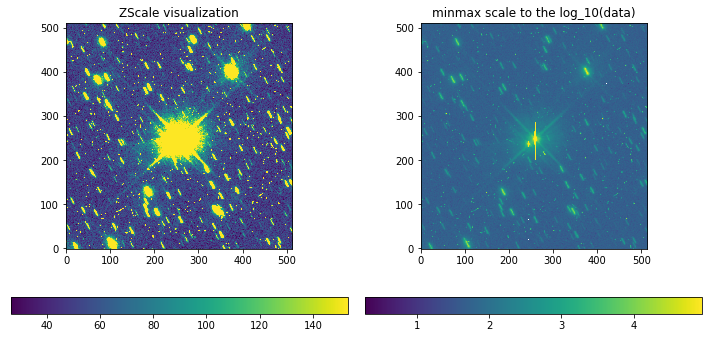

In [3]:
hdul = fits.open(DATAPATH / 'Pluto1.fits')
print(hdul.info())    
    
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].set_title("ZScale visualization")
im1 = zimshow(axs[0], hdul[1].data)
colorbaring(fig, axs[0], im1)

axs[1].set_title("minmax scale to the log_10(data)")
im2 = axs[1].imshow(np.log10(hdul[1].data), origin="lower")
colorbaring(fig, axs[1], im2)

plt.tight_layout()
plt.show()

From the results of ``.info()``, you can see total 9 extensions. The 0-th is the Primary HDU without any data (only header shared by all other extensions). The 1-th is the science HDU with 513 by 512 pixels. The 2-th is the error-map. Other extensions are just other auxiliary results.

Because of this multi extension, we need to **sum** the headers of bothe the extensions 0 and 1 to have all information about ``SCI``, for example.

From the "cross" patterns of bright sources, you can see that there are at least two very bright sources at the center of the image. 

## 5. Proper Input Parameters

You may wonder than which parameter values are the best. Although there is no single best value set, there are some rules of thumb:

> 1. [P. G. van Dokkum](http://www.astro.yale.edu/dokkum/lacosmic/pars.html) suggests **HST WFPC2** (removed from HST on 2009-05-14 UT; replaced with WFC3) gives good results with: `gain=7., readnoise=5., objlim=4 (default), sigclip=4.5 (default), sigfrac=0.3 (default), niter=4 (default)`. `objlim=5` can be used if you want to be more stringent in discriminating CR hit.
> 2. Unlike WFPC3, WFC3 has calibrated image in the unit of electrons per second, not in the unit of ADU. So we need gain to be unity. 



`ccdproc` provides its own ways to do CR rejection: in the classic L.A.Cosmic like way ([`cosmicray_lacosmic`](http://ccdproc.readthedocs.io/en/stable/api/ccdproc.cosmicray_lacosmic.html#ccdproc.cosmicray_lacosmic)), and the [`cosmicray_median`](http://ccdproc.readthedocs.io/en/stable/api/ccdproc.cosmicray_median.html#ccdproc.cosmicray_median). Both are nothing but just `astroscrappy` with different default input parameters, so you don't have to use those.

I will just demonstrate how to use `astroscrappy.detect_cosmics` for CR rejection.

If you have read the documentation above, you will ask how to get the gain and readnoise value (which are input parameters). Everything is in the header as usual. But because HST image has very long header, **let me guide you how to find those information**.

## 5-1. Looking at Header

First, open the image with, e.g., ds9, and copy all the primary and SCI headers to notepad. Then find (e.g., ctrl+F) ``gain``, ``read``, and ``unit``. Then you will get

```
BUNIT   = 'ELECTRONS'          / brightness units                               
...
              / CALIBRATED ENGINEERING PARAMETERS                               
ATODGNA =        0.0000000E+00 / calibrated gain for amplifier A                
ATODGNB =        0.0000000E+00 / calibrated gain for amplifier B                
ATODGNC =        1.5599999E+00 / calibrated gain for amplifier C                
ATODGND =        0.0000000E+00 / calibrated gain for amplifier D                

READNSEA=        0.0000000E+00 / calibrated read noise for amplifier A          
READNSEB=        0.0000000E+00 / calibrated read noise for amplifier B          
READNSEC=        3.0799999E+00 / calibrated read noise for amplifier C          
READNSED=        0.0000000E+00 / calibrated read noise for amplifier D          
...
```
Now you see some words like ``amplifier``. It seems like the amplifier we are using is important. Intuitively it should be C because all other cases you have gain and read noise 0. Indeed, you may find
```
CCDAMP  = 'C   '               / CCD Amplifier Readout Configuration            
```
Now, you can use 
```python
gain = hdul[0].header["ATODGNC"]
readnoise = hdul[0].header["READNSEC"]
```

But there is one more thing to care! The image is in **electrons unit, not in ADU**. Therefore, we have to insert the ``gain`` argument as unity regardless of the header information (because ``BUNIT = 'ELECTRONS'`` means that the gain of 1.5599... was *already* multiplied to all the pixels!).

Keeping these information, we do the following:

/Users/ysbach/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in log10
/Users/ysbach/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in log10


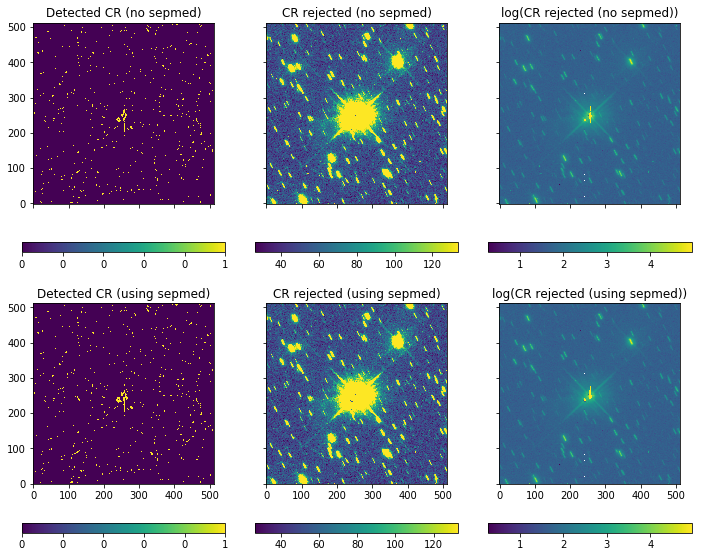

In [4]:
original_data = hdul[1].data
hdr = hdul[0].header + hdul[1].header
gain = 1.0  # not hdr["ATODGNC"] !!!!
readnoise = hdr["READNSEC"]

# Initialize two CCDData objects
ccd_LA = CCDData(data=[0], header=hdr, unit='electron')
ccd_CR = CCDData(data=[0], header=hdr, unit='electron')

# I skipped two params in LACOSMIC: gain=2.0, readnoise=6.
LACOSMIC_KEYS = dict(sigclip=4.5, sigfrac=0.5, objlim=5.0,
                     satlevel=np.inf, pssl=0.0, niter=4,
                     cleantype='medmask', fsmode='median', psfmodel='gauss',
                     psffwhm=2.5, psfsize=7, psfk=None, psfbeta=4.765)

# Following should give identical result to IRAF L.A.Cosmic,
# "m_LA" is the mask image
m_LA, ccd_LA.data = astroscrappy.detect_cosmics(original_data,
                                                sepmed=False,  # IRAF LACosmic is sepmed=False
                                                gain=gain,
                                                readnoise=readnoise,
                                                **LACOSMIC_KEYS)
# obj_LA.write(DATAPATH / 'Pluto1_LA.fits', overwrite=True)


# Following is the "fastest" astroscrappy version. 
m_CR, ccd_CR.data = astroscrappy.detect_cosmics(original_data,
                                                sepmed=True,
                                                gain=gain, 
                                                readnoise=readnoise,
                                                **LACOSMIC_KEYS)
# obj_cr.write(DATAPATH / 'Pluto1_CR.fits', overwrite=True)

fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True)

im_LAm = axs[0, 0].imshow(m_LA.astype(int))
axs[0, 0].set_title('Detected CR (no sepmed)')
colorbaring(fig, axs[0, 0], im_LAm)

im_LA = zimshow(axs[0, 1], ccd_LA.data)
axs[0, 1].set_title('CR rejected (no sepmed)')
colorbaring(fig, axs[0, 1], im_LA)

im_LA_log = axs[0, 2].imshow(np.log10(ccd_LA.data), origin="lower")
axs[0, 2].set_title('log(CR rejected (no sepmed))')
colorbaring(fig, axs[0, 2], im_LA_log)

im_CRm = axs[1, 0].imshow(m_CR.astype(int))
axs[1, 0].set_title('Detected CR (using sepmed)')
colorbaring(fig, axs[1, 0], im_CRm)

im_CR = zimshow(axs[1, 1], ccd_CR.data)
axs[1, 1].set_title("CR rejected (using sepmed)")
colorbaring(fig, axs[1, 1], im_CR)

im_CR_log = axs[1, 2].imshow(np.log10(ccd_CR.data), origin="lower")
axs[1, 2].set_title('log(CR rejected (using sepmed))')
colorbaring(fig, axs[1, 2], im_CR_log)

plt.tight_layout()
plt.show()

* **TIP**: The biggest difference between L.A.Cosmic and astroscrappy is the ``sepmed`` option. If you set ``sepmed=False``, `astroscrappy` will give you the identical result as L.A.Cosmic's IRAF version.
* Here, I found `objlim=5.0` gives reasonable result regardless of other parameters. As you can see, the bright part of the target is regarded as cosmic rays. You can tune `objlim` for your purpose:
> If `objlim` is small, more cosmic rays will be rejected, but bright stars will also be regarded as part of cosmic rays.  
> If `objlim` is large, fewer cosmic rays will be rejected, but bright stars will less likely to be regarded as part of cosmic rays.  



## 6. Comparing Two Results

In real research, you may have to spend some time to remove CRs correctly. If not, the pixels of your object is affected in an unwanted way. Here, I will compare the two results we obtained above, just as a demonstration of how you could do the comparison of many combinations of parameter sets:

1. LA = Using ``sepmed=False`` (Original L.A. Cosmic)
2. CR = Using ``sepmed=True`` (only available via `astroscrappy`)

I analyzed using the ``diff`` which is defined as $ \mathrm{diff} = \frac{CR - LA}{LA} $. The reason I used LA as the denominator is because I want to assume LA as the "correct" result. Traditionally people have been using LA (``sepmed=False``) for the CR rejection technique.

Text(0.5, 1.0, 'diff < 1 (N = 1540)')

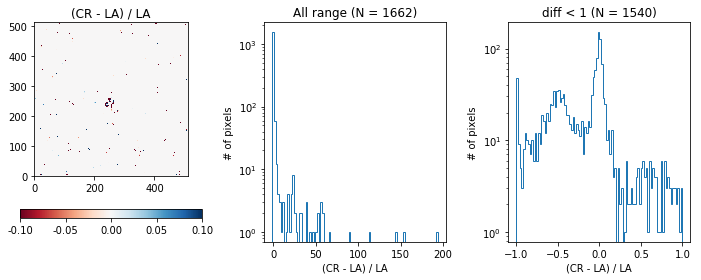

In [5]:
diff = (ccd_CR.data - ccd_LA.data) / ccd_LA.data

fig, axs = plt.subplots(1, 3, figsize=(10, 4))

im = axs[0].imshow(diff, vmin=-0.1, vmax=0.1, origin="lower", cmap="RdBu")
fig.colorbar(im, ax=axs[0], orientation='horizontal', 
             format=FormatStrFormatter("%.2f"))
axs[0].set_title("(CR - LA) / LA")

meaningful_diff = diff[diff != 0]
axs[1].hist(meaningful_diff.ravel(), bins=100, histtype='step')
axs[1].set_yscale("log")
axs[1].set_ylabel("# of pixels")
axs[1].set_xlabel("(CR - LA) / LA")
axs[1].set_title(f"All range (N = {len(meaningful_diff):d})")
plt.tight_layout()

meaningful_diff2 = meaningful_diff[meaningful_diff < 1]
axs[2].hist(meaningful_diff2.ravel(), bins=100, histtype='step')
axs[2].set_yscale("log")
axs[2].set_ylabel("# of pixels")
axs[2].set_xlabel("(CR - LA) / LA")
axs[2].set_title(f"diff < 1 (N = {len(meaningful_diff2):d})")

1. On the left, I drew the ``diff``. You can see that most pixels are unaffected.
2. On the middle is the histogram in log scale.
3. On the right is the histogram but in the range of -1 or higher.

For plotting histogram, I used ``meaningful_diff``, which contains pixel values that have been affected by the CR rejection process. So N=1662 in the title means that there are 1662 pixels which have been modified by the CR rejection process. As you can see, most pixels have ``diff`` nearly 0, which means the difference between two methods are not significant.
(Since CR cannot be negative, the ``diff`` cannot be smaller than -1)

Note that more than 90% (1540 / 1662) have ``diff < 1``, and most are concentrated to ``|diff| < 0.1``. Since the difference we are looking at are the pixels contaminated by CR, this amount of difference is not necessarily important, unless you are seeking for higher accuracy. 

To look at the statistics of the results, you may use convenience function in ``ysfitsutilpy``:
```python
import ysfitsutilpy as yfu
diff_stats = yfu.give_stats(meaningful_diff)
for k, v in diff_stats.items():
    print(f"{k:>12s}: {v}")

diff_stats2 = yfu.give_stats(meaningful_diff2)
for k, v in diff_stats2.items():
    print(f"{k:>12s}: {v}")
```

If you want to do some advanced reduction for HST data, you may use `drizzlepac`. Download it by   
    
    conda install drizzlepac

In Python, you may refer to [this website](http://drizzlepac.readthedocs.io/en/deployment/astrodrizzle.html) for using it as `drizzlepac.astrodrizzle.Astrodrizzle(input="Pluto1.fits", output="final", editpars=True)`. Each parameter should be tuned carefully by referring to the [Drizzlepac Handbook](http://documents.stsci.edu/hst/HST_overview/documents/DrizzlePac/drizzlepac.pdf) (v1.0, 2012)